#### 利用训练模型进行遥感影像分类

In [1]:
import pickle
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from matplotlib import colors


In [2]:
path_model = 'data/Section-7/model_rf.pickle'
path_rsimg= 'data/Section-7/s2_chenggong_20200411_6bands_20m.tif'


In [3]:
## 读入栅格数据
rsimg_rio = rio.open(path_rsimg)
rsimg_rio.meta


{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 1490,
 'height': 1630,
 'count': 6,
 'crs': CRS.from_epsg(32647),
 'transform': Affine(20.0, 0.0, 874420.0,
        0.0, -20.0, 2769600.0)}

In [4]:
rsimg_arr = rsimg_rio.read()
rsimg_arr = rsimg_arr.transpose(1,2,0)
rsimg_arr.shape


(1630, 1490, 6)

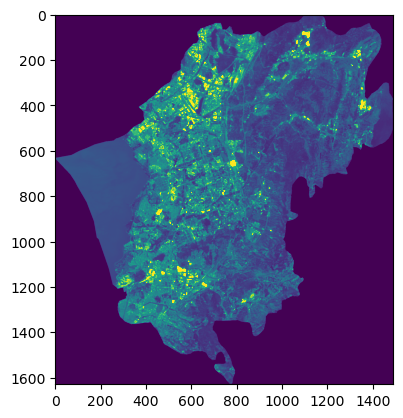

In [5]:
plt.imshow(rsimg_arr[:,:,0], vmax=2000)


In [6]:
### 归一化
rsimg_arr_nor = rsimg_arr/(rsimg_arr.max()-rsimg_arr.min())


In [7]:
rsimg_arr_2d = np.reshape(rsimg_arr_nor, (-1,6))
rsimg_arr_2d.shape


(2428700, 6)

##### 加载模型

In [8]:
with open(path_model, 'rb') as file:
  model_rf = pickle.load(file)


##### 模型预测

In [9]:
y_pred = model_rf.predict(rsimg_arr_2d)


In [10]:
y_pred.shape


(2428700,)

In [11]:
y_pred_img = y_pred.reshape(rsimg_arr.shape[0:2])
y_pred_img.shape



(1630, 1490)

In [12]:
ids = np.where(rsimg_arr[:,:,0]==0)
y_pred_img = np.float32(y_pred_img)
y_pred_img[ids] = np.nan  ## 去除无数据区域


##### 可视化结果

In [13]:
color_list = {0: np.array([0,0,255]),      # water, blue
              1: np.array([0,128,0]),      # vegetation, green
              2: np.array([255,140,0]),    # soil, dark orange
              3: np.array([245,245,220])}  # building
y_pred_img_color = np.full(shape=(y_pred_img.shape[0], 
                                  y_pred_img.shape[1], 3), 
                                  fill_value=-1)

for color_code in color_list.keys():
    y_pred_img_color[y_pred_img==color_code] = color_list[color_code]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


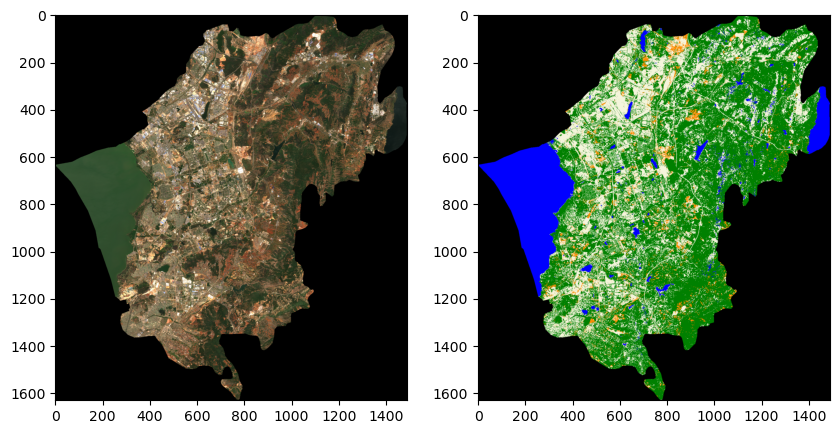

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
band_color = np.stack([rsimg_arr_nor[:,:,2], 
                       rsimg_arr_nor[:,:,1], 
                       rsimg_arr_nor[:,:,0]], axis=2)   ### rgb: red:green:blue;  nir:red:green
band_color = band_color/(0.15-0)   ### 线性拉伸
# ax[0].imshow(rsimg_arr[:,:,0])   ### 单波段显示
ax[0].imshow(band_color)           ### 彩色显示
ax[1].imshow(y_pred_img_color)


#### 保存分类结果

In [31]:
path_result = 'data/Section-7/class_result.tif'
with rio.open(path_result, 'w', driver='GTiff', 
                   height=y_pred_img.shape[0],
                   width=y_pred_img.shape[1],
                   count=1,
                   dtype=np.int16,
                   crs=rsimg_rio.crs,
                   transform=rsimg_rio.transform) as dst:
  dst.write(y_pred_img, 1)   ## the number 1 is the number of bands.


/Users/luo/miniconda3/envs/gis-course/lib/python3.10/site-packages/numpy/core/_asarray.py:126: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)
